# 1 Stock Scraping using yfinance 

In [1]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23909 sha256=c29ba4d4bd9105068dbfa47d965a6d0fdba0a255ff83ec04a1a0afc324bc4d6b
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8368 sha256=d6a8699556f65eb7c0f355e7ada4b68ffa986e8770db365f5add3291e2da2485
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking


In [2]:
%matplotlib inline 
import os
import random
import pandas_datareader.data as web
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from ipywidgets import interact, fixed, IntSlider
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
import seaborn as sns

In [4]:
tickers = ['ITC.NS', 'TCS.NS','HCLTECH.NS','INFY.NS','LT.NS','HDFCBANK.NS']
N = len(tickers)
historical  = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)

[*********************100%***********************]  1 of 1 completed
Loaded ITC.NS num values = 6444
[*********************100%***********************]  1 of 1 completed
Loaded TCS.NS num values = 4443
[*********************100%***********************]  1 of 1 completed
Loaded HCLTECH.NS num values = 4721
[*********************100%***********************]  1 of 1 completed
Loaded INFY.NS num values = 6447
[*********************100%***********************]  1 of 1 completed
Loaded LT.NS num values = 4738
[*********************100%***********************]  1 of 1 completed
Loaded HDFCBANK.NS num values = 6448


# 2 Portfolio return Backtesting using Interactive Chart

,ITC.NS,TCS.NS,HCLTECH.NS,INFY.NS,LT.NS,HDFCBANK.NS
Date,,,,,,
2002-08-12,10.001503,29.519140,15.766702,35.692348,28.743631,18.342995
2002-08-13,10.170523,29.119476,15.476412,35.702301,28.771202,18.491634


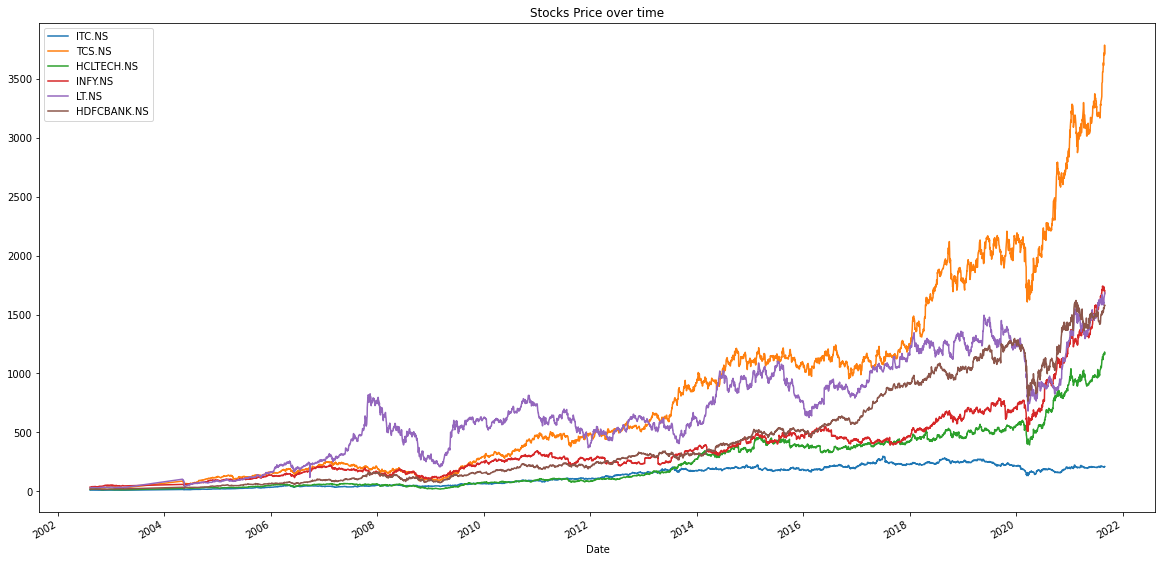

In [5]:
_ = (historical).plot(figsize=(20,10),title='Stocks Price over time')
historical.head(2)

It’s probably a good practice to backfill any missing values inbetween the dates, and chop off data so that selected stocks have the same length

In [6]:
returns = (historical/historical.iloc[0]).fillna(method='backfill')
daily_pct_change = np.log(returns.pct_change() + 1)
vols = daily_pct_change.std() * np.sqrt(252)

Backfill is usually used in time-series as it doesn’t spoil the data from the future to the past.

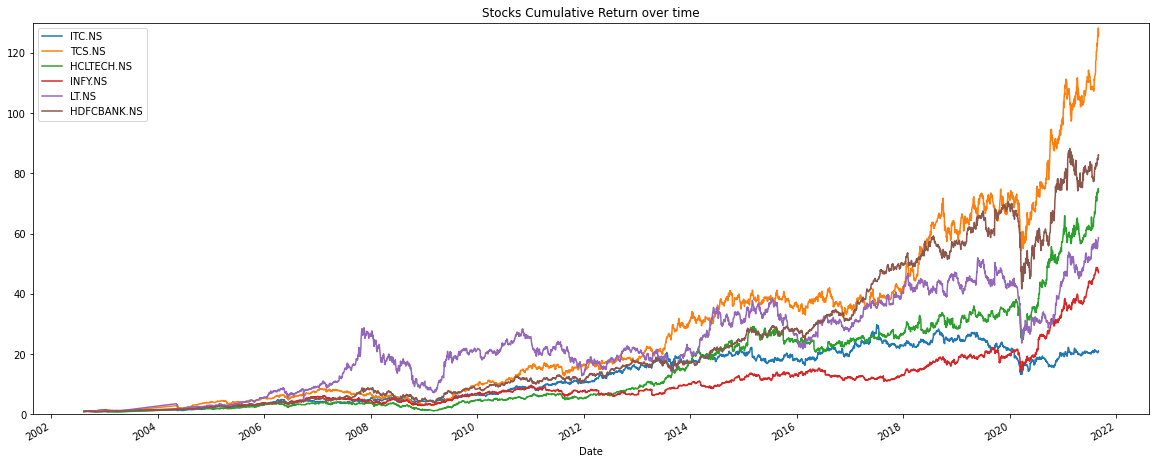

In [7]:
_ = returns.plot(ylim=(0,130), figsize=(20,8),title='Stocks Cumulative Return over time')

It seems fine with me with no obvious breaks and gaps between data. Also, all stock data is available at t= 0 which is good

In [8]:
returns['PORTFOLIO'] = returns.iloc[:,0:N].sum(axis=1) /N

For simplicity, we used 1/N equal-weighted portfolio, meaning that each stock has 1/N weight.

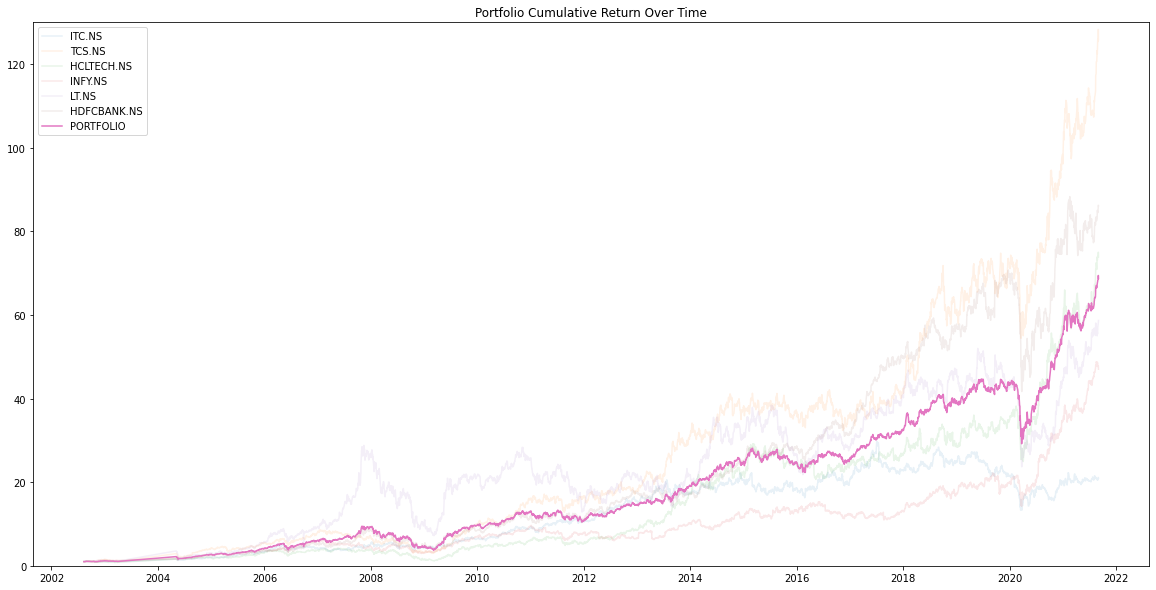

In [9]:
plt.figure(figsize=(20,10))
lines = plt.plot(returns.drop('PORTFOLIO', axis=1), alpha=0.1)
plt.ylim((0,130))
plt.title('Portfolio Cumulative Return Over Time')
plt.plot(returns['PORTFOLIO'], alpha=1)
plt.legend(returns.columns)
plt.show()

In [10]:
daily_pct_change = np.log(returns.pct_change() + 1)
vols = daily_pct_change.std() * np.sqrt(252) # Annual Volatility 

tickers=['ITC.NS', 'TCS.NS','HCLTECH.NS','INFY.NS','LT.NS','HDFCBANK.NS']
prices = [stock_hist(symbol)['Adj Close'] for symbol in tickers]
prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in tickers), axis=1, keys=tickers).dropna(axis=0)
prices.head(2)

,ITC.NS,TCS.NS,HCLTECH.NS,INFY.NS,LT.NS,HDFCBANK.NS
Date,,,,,,
2002-08-12,10.001503,29.519140,15.766702,35.692348,28.743631,18.342995
2002-08-13,10.170523,29.119476,15.476412,35.702301,28.771202,18.491634


In [11]:
def diversicheck(symbols, start_day=0, time_horizon=365, **active):
    filtered = [symbol for symbol in symbols if active.get(symbol, True)]
    prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in filtered), axis=1, keys=filtered).dropna(axis=0)
    
    
    start_dates = prices.index[0] + datetime.timedelta(days = start_day)
    end_dates = start_dates + datetime.timedelta(days=time_horizon)
    
    prices = prices.loc[start_dates:end_dates]
    
    unit_pos = prices / prices.iloc[0,:]
    basket = unit_pos.sum(axis=1) / unit_pos.shape[1]
    unit_pos.plot(figsize=(20,10),title='Stocks Cumulative Return over time', alpha=0.3)
    basket.plot(figsize=(20,10),legend = True)
    print(f'backtest from {start_dates} to {end_dates}')

interactive(children=(IntSlider(value=0, description='start_day', max=2520), IntSlider(value=365, description=…

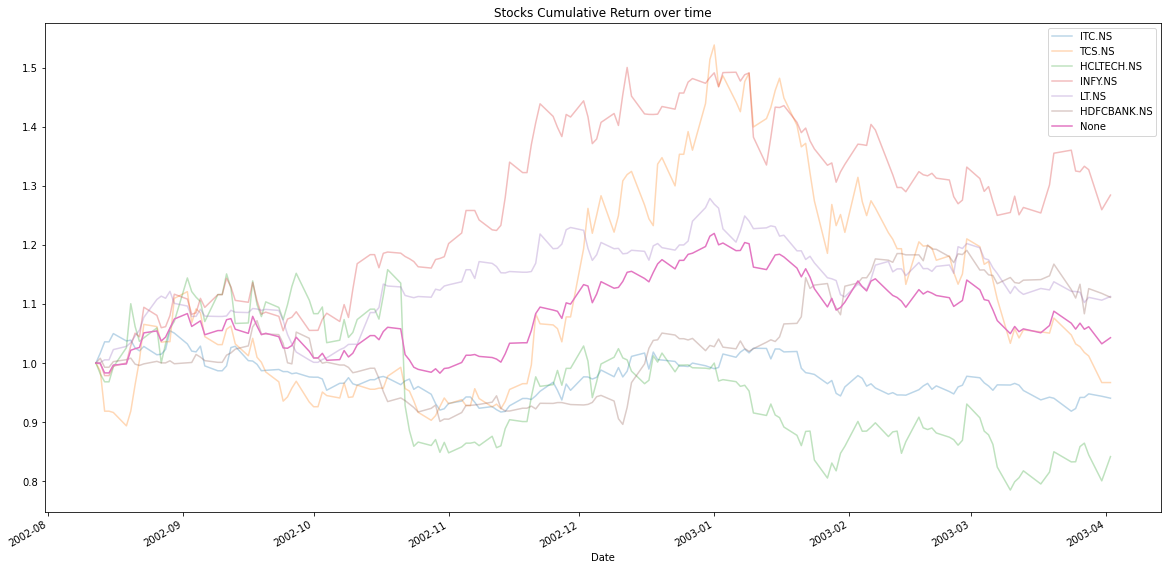

In [12]:
# cached_data ={}
prf_stocks = ['ITC.NS', 'TCS.NS','HCLTECH.NS','INFY.NS','LT.NS','HDFCBANK.NS']
active = dict(zip(prf_stocks, [True] * len(prf_stocks)))
_ = interact(diversicheck, symbols =fixed(prf_stocks), start_day=IntSlider(min=0,max=252*10),
             time_horizon=IntSlider(min=0,value=365,max=252*5),**active)

# Correlation Plot & Risk-Reward Chart

In [13]:
prf_prices = pd.concat((stock_hist(symbol)['Adj Close'] for symbol in prf_stocks), axis =1, keys=prf_stocks).dropna(axis=0)
prf_returns = (prf_prices.pct_change() + 1)[1:]
log_returns = np.log(prf_returns)
corr = log_returns.corr()

<AxesSubplot:>

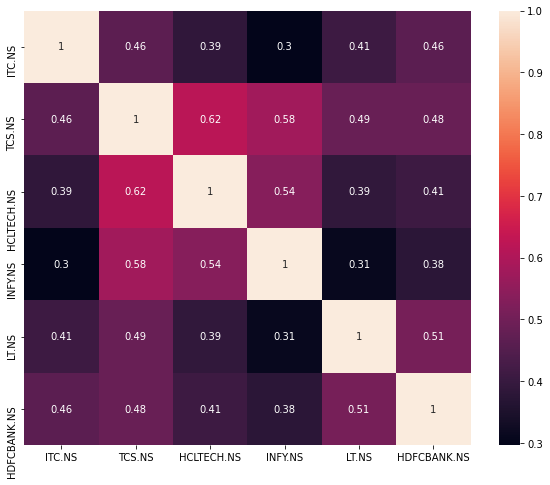

In [14]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr, annot=True)

In [15]:
vols = log_returns.std() * np.sqrt(252)
avg_return = (prf_returns-1).mean()

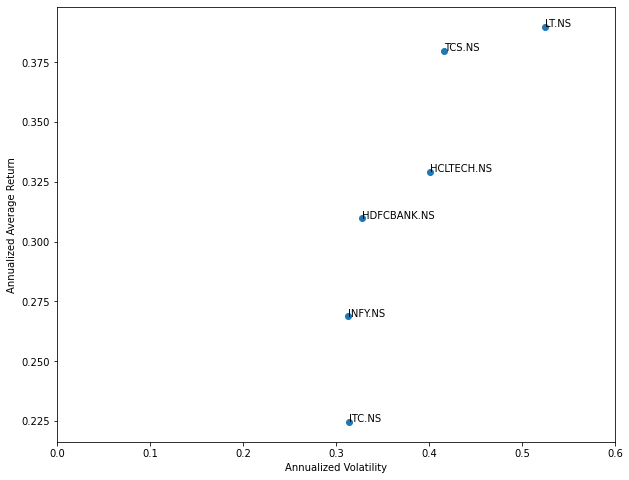

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(vols, avg_return*252)
ax.set_xlabel('Annualized Volatility')
ax.set_ylabel('Annualized Average Return')
ax.set_xlim(0,0.6)
for i, txt in enumerate(prf_stocks):
    ax.annotate(txt, xy=(vols[i], avg_return[i]*252))

# Monti-Carlo Simulation of Portfolio Return

In [17]:
number_of_simulations = 1000
investment_horizon = 60
simulated = pd.DataFrame([(prf_returns.iloc[random.choices(
    range(len(prf_returns)), k=investment_horizon)]).mean(axis=1).cumprod().values 
                         for x in range(number_of_simulations)]).T
simulated.head(3)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.017032,0.992795,0.993634,1.010974,1.000382,0.983941,0.998261,1.006534,0.998692,1.008381,...,1.000796,1.013463,1.010939,1.012916,1.003088,0.994675,0.997734,1.006811,1.004951,0.997659
1,1.018528,1.021735,0.987758,1.023310,0.990694,0.986421,1.015245,1.025492,1.016550,1.015849,...,1.003432,1.008419,1.009972,1.003182,1.011558,1.002942,0.996663,0.996964,1.003985,0.989462
2,1.008923,1.026391,0.985254,1.026788,0.998784,0.994791,1.031607,1.025492,1.053404,1.028235,...,1.000182,1.010969,1.038819,0.981618,1.032049,1.010479,0.978270,0.991431,1.008438,0.986119


We randomly select the return from past and form synthetic returns for all the stocks over time-horizon (k = 60 days in this case), and we calculated our portfolio based on those synthetic returns. In this example, we simulate for 1,000 times, and get the confidence interval of our portfolio value after 60 days.

<AxesSubplot:>

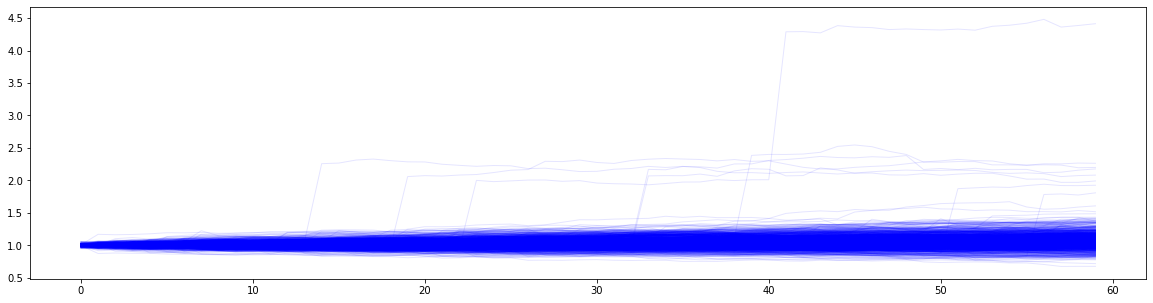

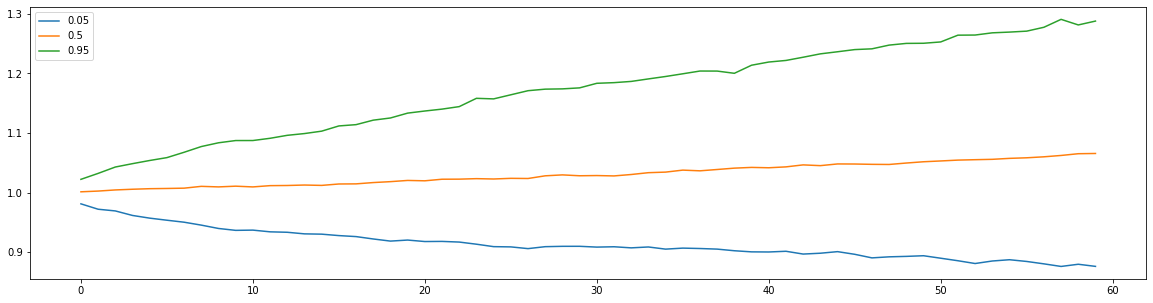

In [18]:
simulated.plot(legend=False, linewidth=1, alpha=0.1, color='blue', figsize=(20,5))
simulated.quantile([0.05, 0.50, 0.95], axis=1).T.plot(figsize=(20,5))